In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('./dataset/spam.csv', encoding = 'ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# v1 -> labels, v2 -> data
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# 이진분류
#df.loc[df['labels'] == 'ham', 'b_labels'] = 0
#df.loc[df['labels'] == 'spam', 'b_labels'] = 1

In [7]:
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

In [8]:
df

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [9]:
Y = df['b_labels'].values
Y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(df['data'], Y,
                                                    test_size = 0.33)

In [11]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

X_train: (3733,), X_test: (1839,), Y_train: (3733,), Y_test: (1839,)


In [12]:
MAX_VOCAB_SIZE = 20000

In [13]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE) # 사용 빈도가 높은 20000개 단어.
tokenizer.fit_on_texts(X_train) # 토큰화 작업

In [14]:
# sequence 데이터처럼 분류 -> padding,,,
sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test) # scaler처럼 X_test에는 texts_to_sequences만 해줌.

In [15]:
#print(sequence_train)

In [16]:
# 개별의 벡터화 - Word2Vec{CBoW (Continuous Bag of Words) & Skip-gram} 둘 다 특정 타깃 단어 주변의 문맥, 즉 분포 정보를 임베딩에 포함합니다.
word2vec = tokenizer.word_index
V = len(word2vec)
print('Unique token:', V)

Unique token: 7216


In [17]:
# N X T -> 데이터 길이가 다 다르기 때문에 길이를 맞춰줘야 함. -> padding
data_train = pad_sequences(sequence_train)
data_train.shape

(3733, 189)

In [18]:
T = data_train.shape[1] # time series
T

189

In [19]:
data_test = pad_sequences(sequence_test, maxlen = T) # 데이터 길이 맞춰줌.(sequence_train와 열의 개수 똑같)
data_test.shape

(1839, 189)

### Generate a model

In [20]:
# embedding -> 차수 변경. / 밀집 벡터 (전체 데이터 수, input layer 수)
# embedding -> 2차원 배열
# 이진분류

D = 20 # 차원
M = 15 # projection layer 사이즈 지정.

i = Input(shape = (T,)) # time series
x = Embedding(V + 1, D)(i) # 처음 시작하는 인덱스 때문에 문제 해결을 위해.(1부터 들어가니까.) - 임베딩 차원(그 개수만큼 벡터 생성)
x = LSTM(M, return_sequences = True)(x) # many to many
x = GlobalMaxPool1D()(x) # 인자값으로 받는다. -> GlobalMaxPool1D()
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 embedding (Embedding)       (None, 189, 20)           144340    
                                                                 
 lstm (LSTM)                 (None, 189, 15)           2160      
                                                                 
 global_max_pooling1d (Globa  (None, 15)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 146,516
Trainable params: 146,516
Non-trainable params: 0
_______________________________________________________

In [22]:
r = model.fit(data_train, Y_train, epochs = 10, validation_data = (data_test, Y_test))

Epoch 1/10
117/117 [==============================] - 5s 39ms/step - loss: 0.4693 - accuracy: 0.8599 - val_loss: 0.3896 - val_accuracy: 0.8679
Epoch 2/10
117/117 [==============================] - 4s 37ms/step - loss: 0.3933 - accuracy: 0.8650 - val_loss: 0.3855 - val_accuracy: 0.8679
Epoch 3/10
117/117 [==============================] - 4s 38ms/step - loss: 0.3851 - accuracy: 0.8650 - val_loss: 0.3715 - val_accuracy: 0.8679
Epoch 4/10
117/117 [==============================] - 4s 37ms/step - loss: 0.3072 - accuracy: 0.8650 - val_loss: 0.2030 - val_accuracy: 0.8679
Epoch 5/10
117/117 [==============================] - 4s 38ms/step - loss: 0.1327 - accuracy: 0.9794 - val_loss: 0.0984 - val_accuracy: 0.9864
Epoch 6/10
117/117 [==============================] - 4s 37ms/step - loss: 0.0745 - accuracy: 0.9922 - val_loss: 0.0730 - val_accuracy: 0.9886
Epoch 7/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0451 - accuracy: 0.9960 - val_loss: 0.0597 - val_accuracy: 0.9875

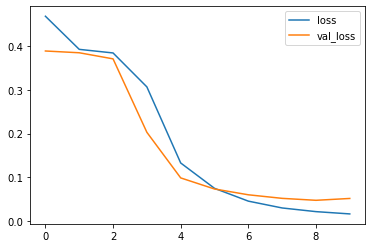

In [23]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

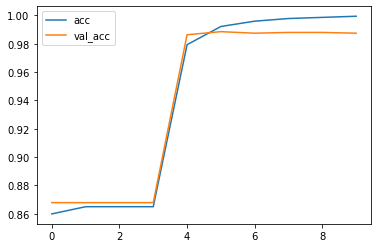

In [24]:
plt.plot(r.history['accuracy'], label = 'acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()

In [25]:
spam_email = '''As kids, we all learned by doing. We just called it playing. 
               And playing is how kids learn everything from complex social interactions to coding to 
               dinosaur names. Knowing your stegosaurus from your qianzhousaurus may not be all that 
               important as an adult, but we all still have that inner 10-year-old that loves to learn by playing. 
               Our Cloud Playground gives you the freedom to build, test, fail, and learn in completely real, 
               completely risk-free AWS, Azure, and GCP sandbox environments.'''

In [58]:
ham_email = '''So then I was posted to LA, which felt like a whole other country compared with the East Coast. I could definitely get used to that kind of outdoor, beach lifestyle, but I didn't spend as much time getting to know California as I could have because I was flying back to see Michael every other weekend. He came to see me when he could, but his job means he's often working at weekends, so he couldn't make the flight very often.'''

In [27]:
sample_email_sequences = tokenizer.texts_to_sequences([spam_email])

In [29]:
sample_email_padding = pad_sequences(sample_email_sequences, maxlen = T)

In [30]:
model.predict(sample_email_padding)

array([[0.00719288]], dtype=float32)

In [31]:
score = float(model.predict(sample_email_padding))

if score > 0.5:
    print('{:.2f} 확률로 Ham 메일입니다.'.format(score * 100))
else:
    print('{:.2f} 확률로 Spam 메일입니다.'.format((1 - score) * 100))

99.28 확률로 Spam 메일입니다.


In [32]:
# 모델 평가
model.evaluate(data_train, Y_train)

117/117 [==============================] - 1s 8ms/step - loss: 0.0130 - accuracy: 0.9995


[0.013044406659901142, 0.999464213848114]

In [59]:
sample_email_sequences = tokenizer.texts_to_sequences([ham_email])

In [60]:
sample_email_padding = pad_sequences(sample_email_sequences, maxlen = T)

In [61]:
score = float(model.predict(sample_email_padding))

if score > 0.5:
    print('{:.2f} 확률로 Ham 메일입니다.'.format(score * 100))
else:
    print('{:.2f} 확률로 Spam 메일입니다.'.format((1 - score) * 100))

99.38 확률로 Spam 메일입니다.


In [ ]:
# ham mail인데 spam mail로 구별해,,